In [ ]:
import sys as sys

print(sys.path)
# If running notebook outside of CellUntangler directory, add it to the path
sys.path.append('/content/CellUntangler/')

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython']


In [ ]:
import os

import torch

from src.data.umi_data import UMIVaeDataset
from src.celluntangler import utils
from src.celluntangler.models import Trainer
from src.celluntangler.models.nb_vae import NBVAE
import numpy as np

import pandas as pd
import scanpy as sc

# Myeloid Cells CellUntangler Tutorial

We will apply CellUntangler to a dataset of myeloid cells to capture the cell cycle in one latent representation and non-cell cycle signals in another representation.
This dataset contains both cycling and non-cycling cells.


The dataset can be accessed at: [Myeloid](https://drive.google.com/file/d/1JIxQkXnXDidHztvaO-L_4SItfyk5JuGr/view?usp=sharing). The macrophages have already been filtered out. The raw counts are contained in .X and layers["counts"].

## Read in and process the data.

In [ ]:
myeloid_dataset_path = "/content/drive/MyDrive/mvae_research/datasets/immune_cell_dataset/myeloid/myeloid_subset_2.h5ad"
adata = sc.read_h5ad(myeloid_dataset_path)

In [ ]:
adata

AnnData object with n_obs × n_vars = 29376 × 36601
    obs: 'Organ', 'Donor', 'Chemistry', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype', 'Sex', 'Age_range', 'ccPhase'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_name'
    uns: 'Age_range_colors', 'Sex_colors', 'hvg', 'log1p'
    obsm: 'X_umap'
    layers: 'X_original', 'counts'

Select the highly variable genes.

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

Make sure to replace the preprocessed data with the raw counts once again.

In [ ]:
adata.X = adata.layers["counts"].copy()

Read in the cell cycle marker genes that will be used to capture the cell cycle signal.
The cell cycle marker genes can be accessed at: [CellUntangler Cell Cycle Marker Genes](https://drive.google.com/file/d/1DIh9Jfc0vS3-fETCHm1ClxOQTHQB_-ef/view?usp=sharing).

In [ ]:
cell_cycle_genes_path = "/content/drive/MyDrive/mvae_research/cyc_gene_2023_1219_v1.tsv"
cell_cycle_genes = pd.read_csv(cell_cycle_genes_path, header=None, sep="\t")

Select both the highly variable genes and the cell cycle marker genes as selecting only the highly variable genes will result in many cell cycle marker genes being filtered out.

In [ ]:
# Genes involved with the cell cycle present in adata
contained_cell_cycle_genes = adata.var["gene_name"].isin(cell_cycle_genes[0])
kept_genes = adata.var["highly_variable"] | contained_cell_cycle_genes
print("Number of kept genes after filtering for highly variable and cell cycle genes:", np.sum(kept_genes))
adata = adata[:, kept_genes]

Number of kept genes after filtering for highly variable and cell cycle genes: 1903


Rearrange the genes so that cell cycle marker genes are placed first followed by the rest of the non-cell cycle genes.

In [ ]:
# Genes involved with the cell cycle present in adata
contained_cell_cycle_genes = adata.var["gene_name"].isin(cell_cycle_genes[0])
print(f"Number of cell cycle genes present in adata: {np.sum(contained_cell_cycle_genes)}")
cycle_gene_indices = np.where(contained_cell_cycle_genes)[0]
non_cycle_gene_indices = np.where(~contained_cell_cycle_genes)[0]
rearranged_indices = np.hstack((cycle_gene_indices, non_cycle_gene_indices))
adata = adata[:, rearranged_indices]
adata.uns["new_gene_ordering"] = rearranged_indices

Number of cell cycle genes present in adata: 220


<ipython-input-57-9bfa7e71a0e4>:8: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["new_gene_ordering"] = rearranged_indices


## Obtain the configuration for the hyperparameters for the CellUntangler model and for training the model.

In [ ]:
from src.celluntangler.models.get_config import get_config

In [ ]:
config = get_config()

To capture the cell cycle in one representation, we use the hyperbolic space with the rotated wrapped normal distribution (RoWN) with a dimension of 2, which is denoted as r2.

To capture the non-cell cycle signals in the other representation, we use the Euclidean space with a dimension of 10, which is denoted as e10.

Hence the model name is r2, e10.

In [ ]:
config.model_name = "r2, e10"

In [ ]:
config.seed = 68715

Set initialization to "custom", because we are training for the cell cycle.

In [ ]:
config.init = "custom"

## Create the training and test datasets.

This dataset has two batch effects that we will account for, Chemistry and Donor.

In [ ]:
x = adata.X.todense().astype(np.double)
chemistry_batch = adata.obs['Chemistry'].rank(method='dense').astype(int).values.reshape(-1, 1)-1
donor_batch = adata.obs['Donor'].rank(method='dense').astype(int).values.reshape(-1, 1)-1
batch = np.hstack((chemistry_batch, donor_batch))
# y holds the batch vector for the dataset
y = batch

Chemistry has 3 different labels and Donor has 12 different labels, so config.n_batch = [3, 12].

In [ ]:
config.n_batch = [3, 12]

In [ ]:
# Create the dataset and separate it into training and test sets
in_dim = x.shape[1]
print(f"in_dim = {in_dim}")
batch_size = config.batch_size
dataset = UMIVaeDataset(batch_size=batch_size, in_dim=in_dim)
print(f"dataset.in_dim = {dataset.in_dim}")
# Create the dataset loaders
train_loader = dataset.create_loaders(x, y, seed=config.seed)

in_dim = 1903
dataset.in_dim = 1903
Dataset seed: 68715


## Create the mask to be used to separate $\mathbf{x}$ into different components that are used when training the model.

In [ ]:
# A mask that is 1 where the gene is a cell cycling gene and 0 otherwise
mask_cyc = np.zeros(adata.n_vars)
mask_cyc[adata.var["gene_name"].isin(cell_cycle_genes[0])] = 1

# A mask that is 0 where the gene is a cell cycling gene and 1 otherwise
mask_all = np.ones(adata.n_vars)
mask_all[adata.var["gene_name"].isin(cell_cycle_genes[0])] = 0

mask = torch.tensor([mask_cyc, mask_all])

<ipython-input-22-8718f70095e0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  mask = torch.tensor([mask_cyc, mask_all])


In [ ]:
for row in mask:
  print(row)
  print(torch.sum(row).item())

tensor([1., 1., 1.,  ..., 0., 0., 0.], dtype=torch.float64)
220.0
tensor([0., 0., 0.,  ..., 1., 1., 1.], dtype=torch.float64)
1683.0


## Train CellUntangler.

In [ ]:
torch.set_default_dtype(torch.float64)

Below is to save embeddings generated through the epochs. Set visualization_information = None if it is not desired.

In [ ]:
# The path to save the intermediate embeddings to
epoch_embeddings_save_path = "./"
visualize_information={}
# The epochs to save the intermediate embeddings for
visualize_information["epochs"]=[i for i in range(0, 500, 50)]
visualize_information["x"]=x
visualize_information["y"]=y
visualize_information["embeddings_save_path"]=epoch_embeddings_save_path
visualize_information["model_name"]=config.model_name

In [ ]:
config

activation: gelu
batch_invariant: true
batch_size: 128
device: cpu
end: 1.0
end_epoch: 1
end_z2_no_grad: 500
epochs: 200
eps: 0.001
fixed_curvature: true
gain: 1.0
h_dim: 32
init: custom
learning_rate: 0.001
max_epochs: 500
model_name: r2, e10
momentum: 0.99
n_batch:
- 3
- 12
scalar_parametrization: false
seed: 68715
start: 1.0
start_z2_no_grad: 0
use_adamw: true
use_batch_norm: false
use_z2_no_grad: false
weight_decay: null

In [ ]:
if config.seed:
    print(config.seed)
    torch.manual_seed(config.seed)
    np.random.seed(config.seed)
    np.random.default_rng(config.seed)

model_name = config.model_name
components = utils.parse_components(model_name, config.fixed_curvature)
# =====
model = NBVAE(h_dim=config.h_dim,
              components=components,
              mask=mask,
              dataset=dataset,
              config=config).to(config.device)

trainer = Trainer(model)

optimizer = trainer.build_optimizer(learning_rate=config.learning_rate,
                                        fixed_curvature=config.fixed_curvature,
                                        use_adamw=config.use_adamw,
                                        weight_decay=config.weight_decay)

betas = utils.linear_betas(config.start,
                           config.end,
                           end_epoch=config.end_epoch,
                           epochs=config.epochs)

trainer.train_epochs(optimizer=optimizer,
                       train_data=train_loader,
                       betas=betas,
                       likelihood_n=0,
                       max_epochs=config.max_epochs,
                           visualize_information=visualize_information)

68715
Linear(in_features=32, out_features=2, bias=True)
initializing Xavier uniform weights in Linear
Linear(in_features=32, out_features=2, bias=True)
initializing Xavier uniform weights in Linear
RotatedHyperbolicComponent(R^3)
	TrainEpoch 0:	{'bce': -879.4006130138275, 'kl': 5.725846147467528, 'elbo': -885.1264591612947, 'll': 0.0, 'mi': 0.0, 'cov_norm': 0.0, 'beta': 1.0, 'comp_000_r2/curvature': -2.0000000000000004, 'comp_001_e10/curvature': 0.0}
	TrainEpoch 1:	{'bce': -804.7034878383184, 'kl': 3.5161494141717275, 'elbo': -808.2196372524893, 'll': 0.0, 'mi': 0.0, 'cov_norm': 0.0, 'beta': 1.0, 'comp_000_r2/curvature': -2.0000000000000004, 'comp_001_e10/curvature': 0.0}
	TrainEpoch 2:	{'bce': -777.7550822207488, 'kl': 5.26984795784617, 'elbo': -783.0249301785943, 'll': 0.0, 'mi': 0.0, 'cov_norm': 0.0, 'beta': 1.0, 'comp_000_r2/curvature': -2.0000000000000004, 'comp_001_e10/curvature': 0.0}
	TrainEpoch 3:	{'bce': -767.3988788713303, 'kl': 5.493055249888641, 'elbo': -772.8919341212189,

Save the trained embeddings.

In [ ]:
embeddings_save_path = "./"
a = trainer.model(torch.log1p(torch.tensor(x)), torch.tensor(y))
np.savetxt(os.path.join(embeddings_save_path, f'{model_name}_all_encode_v63_z_params.txt'), a[4].detach().numpy())

## Evaluate and analyze the embeddings.

### Visualize the embeddings.

In [ ]:
import matplotlib.pyplot as plt

from src.visualization.helpers import split_embeddings
from src.visualization.visualization_functions import visualize_poincare_from_lorentz, compute_umap

In [ ]:
embeddings_save_path = "./"
model_name = "r2, e10"
# Load in the embeddings
embeddings = np.loadtxt(os.path.join(embeddings_save_path, f'{model_name}_all_encode_v63_z_params.txt'))

In [ ]:
# Returns a dictionary where the keys are of the format componenti_subspace
# E.g., r2, e10 would result in keys of component1_r2 and component2_e10
# The values are the corresponding embeddings
component_embeddings = split_embeddings(model_name, embeddings)
for c in component_embeddings:
    adata.obsm[c] = component_embeddings[c]

r2 3
e10 10


#### Visualize cell cycle component.

Visualize $\mathbf{z}^1 \in \mathbb{H}^2$ when projected to Poincare coordinates and colored by cell cycle phase and the cell type.

Cell cycle phases were assigned using Revelio which assigns a cell cycle stage to each cell although some cells may be assigned no cell cycle stage which is why the stage of some cells is "Unknown".

-2
0.7
Index(['G1.S', 'G2', 'G2.M', 'M.G1', 'S', 'Unassigned'], dtype='object')


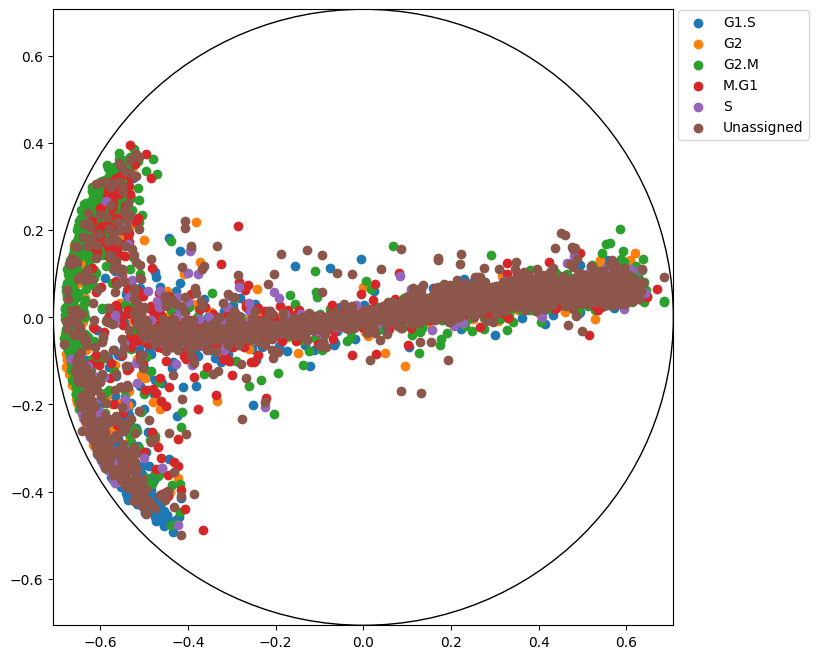

In [ ]:
embeddings_key = "component1_r2"
desired_obs = 'ccPhase'
desired_obs_all = adata.obs[desired_obs]
legend_coordinates = (1.23,1.01)
fig = visualize_poincare_from_lorentz(adata.obsm[embeddings_key],
                       desired_obs_all,
                       curvature=-2,
                      embedding_type='discrete',
                       cmap=plt.cm.viridis,
                       cat_colors=None,
                      grid_lines=True,
                      c_bar_label="Transcriptional Phase",
                      bbox_to_anchor=legend_coordinates)

-2
0.7
Index(['Classical monocytes', 'Cycling', 'DC1', 'DC2', 'MNP/T doublets',
       'Nonclassical monocytes', 'migDC'],
      dtype='object')


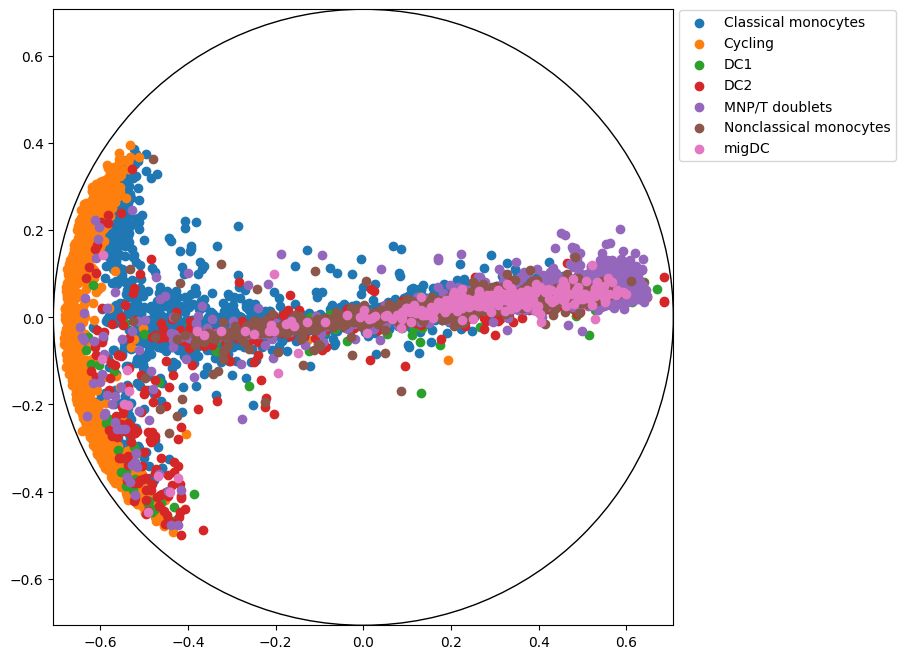

In [ ]:
embeddings_key = "component1_r2"
desired_obs = 'Manually_curated_celltype'
desired_obs_all = adata.obs[desired_obs]
legend_coordinates = (1.37,1.01)
fig = visualize_poincare_from_lorentz(adata.obsm[embeddings_key],
                       desired_obs_all,
                       curvature=-2,
                      embedding_type='discrete',
                       cmap=plt.cm.viridis,
                       cat_colors=None,
                      grid_lines=True,
                      c_bar_label="Transcriptional Phase",
                      bbox_to_anchor=legend_coordinates)

#### Recenter the cycling cells to be around the non-cycling cells

As seen when colored by cell type, the cycling cells (in orange) are at the edge of the Poincare disc whereas the rest of cells spread throughout the middle of the disc and overlap with each other.

We will recenter the orgin so that the cycling cells (in orange) form a circle around the non-cycling cells. Visually, we recommend choosing the origin to be across from the cycling cells, approximately halfway between them and near the edge of the Poincare disc, so we choose the new origin to be (0.55, 0.0).

After recentering the origin, it is clearer to see that the cells separate by cell cycle stage and proceed in the expected order (G1.S $\rightarrow$ S $\rightarrow$ G2 $\rightarrow$ G2.M $\rightarrow$ M.G1).

In [ ]:
from src.visualization.helpers import lorentz_to_poincare, poincare_translation
from src.visualization.visualization_functions import visualize_poincare

In [ ]:
new_origin=(0.55,0.0)
poincare_coordinates=lorentz_to_poincare(adata.obsm["component1_r2"],curvature=-2)
translated_poincare_coordinates=poincare_translation(np.array(new_origin),poincare_coordinates,curvature=-2)

-2
0.7
Index(['G1.S', 'G2', 'G2.M', 'M.G1', 'S', 'Unassigned'], dtype='object')


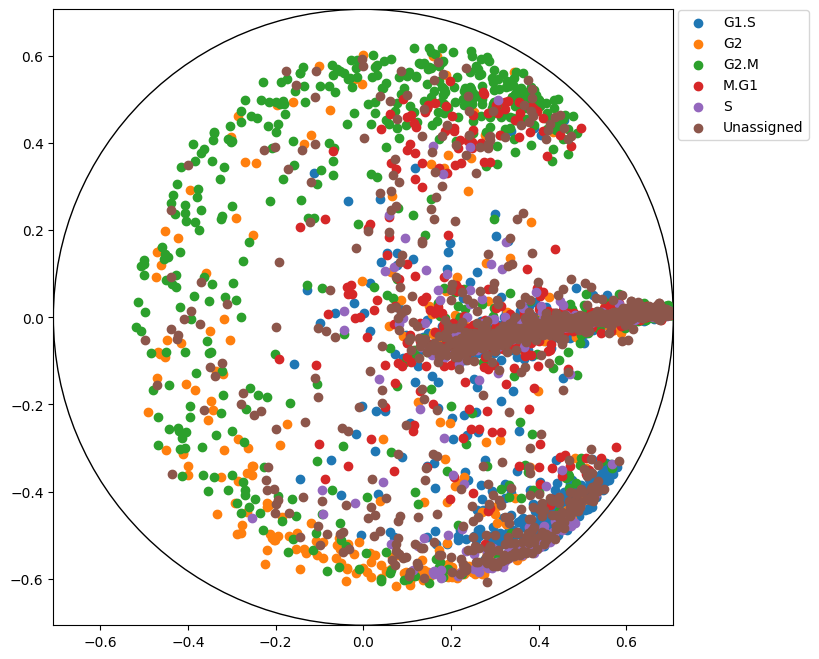

In [ ]:
desired_obs = "ccPhase"
desired_obs_all = adata.obs[desired_obs]
legend_coordinates = (1.23, 1.01)
fig = visualize_poincare(translated_poincare_coordinates,
                   desired_obs_all,
                   curvature=-2,
                   embedding_type="discrete",
                   grid_lines=True,
                   bbox_to_anchor=legend_coordinates)

-2
0.7
Index(['Classical monocytes', 'Cycling', 'DC1', 'DC2', 'MNP/T doublets',
       'Nonclassical monocytes', 'migDC'],
      dtype='object')


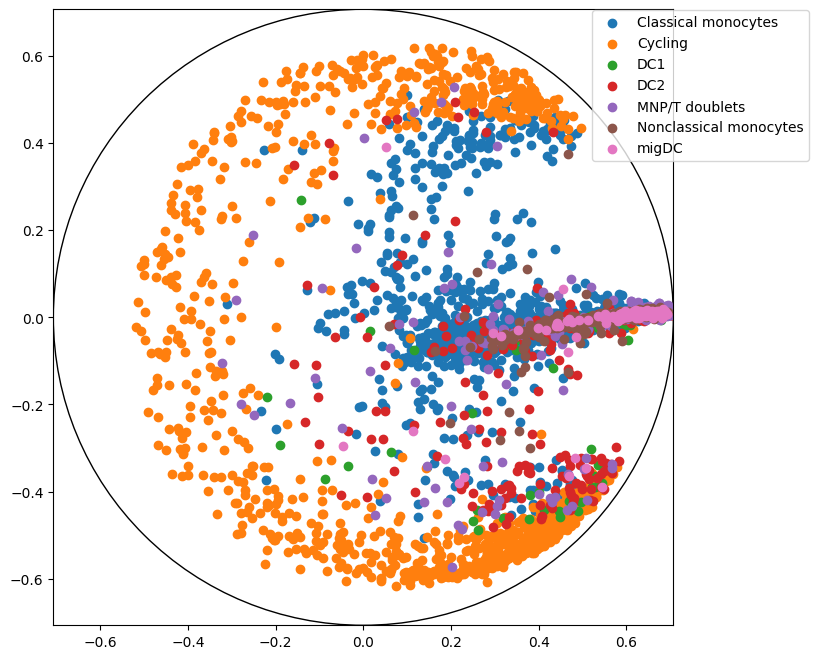

In [ ]:
desired_obs = "Manually_curated_celltype"
desired_obs_all = adata.obs[desired_obs]
legend_coordinates = (1.23, 1.01)
fig = visualize_poincare(translated_poincare_coordinates,
                   desired_obs_all,
                   curvature=-2,
                   embedding_type="discrete",
                   grid_lines=True,
                   bbox_to_anchor=legend_coordinates)

#### Visualize non-cell cycle component.

Visualize $\mathbf{z}^2 \in \mathbb{E}^{10}$ when projected to 2D using UMAP and colored by cell cycle phase and cell type. The cells are mixed by cell cycle and separated by cell type. The separation by cell type is excepting the cycling cells which should be integrated since the effects of the cell cycle are removed, the cycling cells no longer form their own cluster.

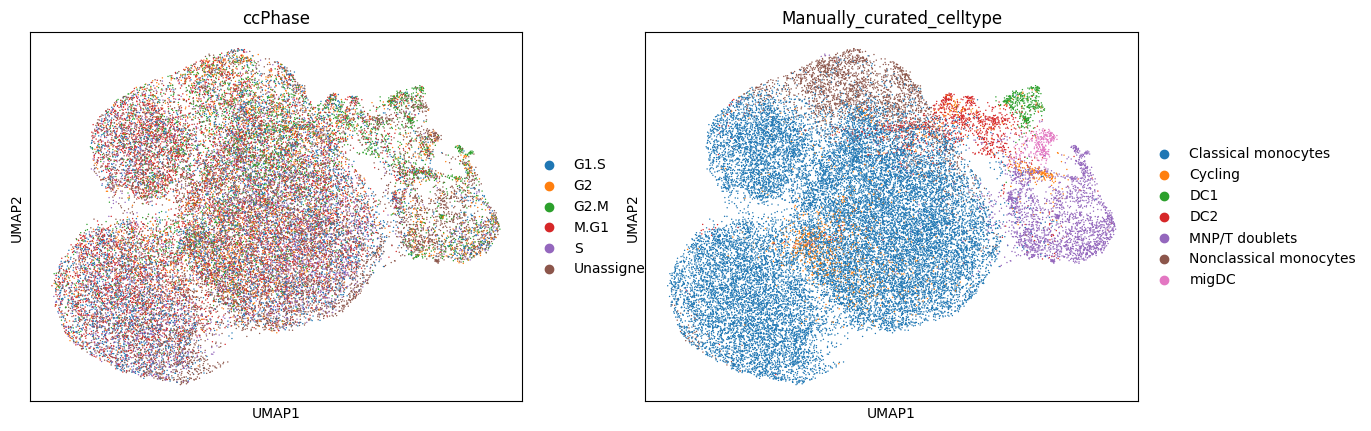

In [ ]:
compute_umap(adata,
             l_neighbors=80,
             color=['ccPhase','Manually_curated_celltype'],
             n_pcs=None,
             embeddings_key="component2_e10",
             use_original_umap=False,
             palette=None,
             additional_save_information=[],
             title=None,
             save_figure=False)

Visualize $\mathbf{z} \in \mathbb{E}^{10}$ when projected to 2D using UMAP when colored by the different batches present in the dataset. The cells are mixed by Chemistry and Donor, the batch effects we accounted for.

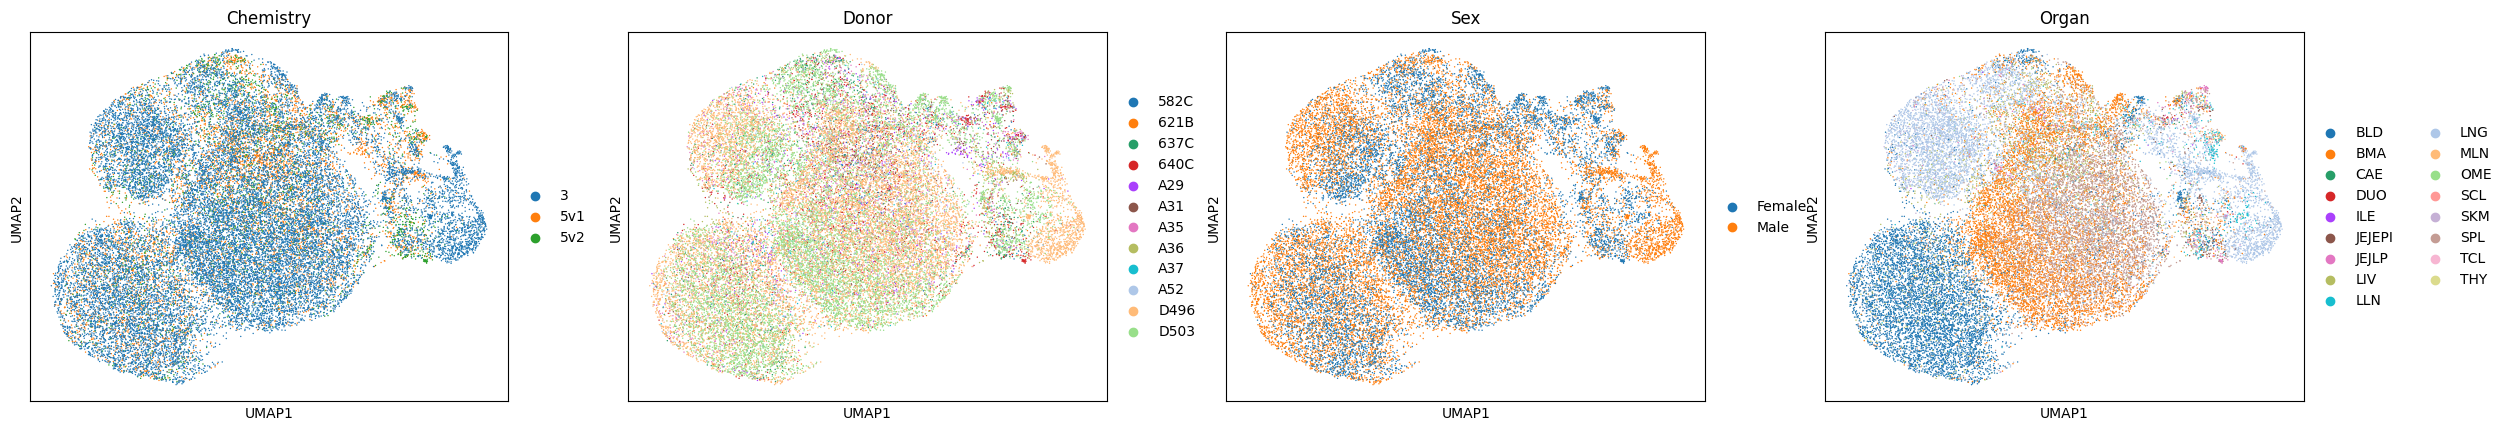

In [ ]:
compute_umap(adata,
             l_neighbors=80,
             color=["Chemistry","Donor","Sex","Organ"],
             n_pcs=None,
             embeddings_key="component2_e10",
             use_original_umap=False,
             palette=None,
             additional_save_information=["batch_effect"],
             title=None,
             save_figure=False)